In [26]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import trapz
from posterior_inference_point import PointSourcePosterior
from posterior_inference_diffuse import DiffusePosterior
import os
from scipy.integrate import cumtrapz

colors = [c["color"] for c in plt.rcParams['axes.prop_cycle']]

In [78]:
### Setup
n_pbhs = np.array([[1,  1,     10],
                   [80, 24000, 80]]).T
m_pbhs = np.array([[0.5, 10, 100],
                   [0.5, 10, 100]]).T

# LIGO's prior ("J" or "LF")
merger_rate_prior = "J" 

# sigma-v prior ("U" or "LF")
sv_prior = "U"

# BSM 95% contours
gambit_dir = "data/gambit/"
gambit_models = ["CMSSM", "MSSM7", "NUHM1", "NUHM2"]#, "SingletDM"]
gambit_grid_rows, gambit_grid_cols = 101, 203

# Colors
pbh_colors = {0.5: colors[0], 10: colors[1], 100: colors[2]}

In [110]:
def plot_gambit_contour_envelope(ax, color=None, padding=10, level=6):
    # TODO: Christoph said 3, not 6...
    # Construct parameter meshgrid
    m_dm_g = np.logspace(1, 4, gambit_grid_cols)[padding:]
    sv_g = np.logspace(-45, -23, gambit_grid_rows)[padding:]
    m_dm_g_mg, sv_g_mg = np.meshgrid(m_dm_g, sv_g)

    #Add the singlet contour separately
    singlet_contour = np.load(
            "{}contours_SingletDM.npy".format(gambit_dir)).T[padding:, padding:]
    ax.contourf(m_dm_g_mg, sv_g_mg, singlet_contour, levels=[0, level], alpha=0.2,
                colors=[color])
    
    # Construct envelope of contours
    envelope = np.inf * np.ones([gambit_grid_rows - padding, gambit_grid_cols - padding])
    for model in gambit_models:
        gambit_data = np.load(
            "{}contours_{}.npy".format(gambit_dir, model)).T#[padding:, padding:]
        
        gambit_contour = gambit_data[padding:, padding:]
        envelope = np.min([envelope, gambit_contour], axis=0)
    
    ax.contourf(m_dm_g_mg, sv_g_mg, envelope, levels=[0, level], alpha=0.35,
                colors=[color])
    

0.5 1 1.0614992931030516e-29
0.5 1 7.274945116298835e-29
0.5 80 1.148446932703555e-43
0.5 80 1.164272887513047e-43
10.0 1 3.4185504093234203e-29
10.0 1 7.535233664295939e-29
10.0 24000 1.9651606771163124e-39
10.0 24000 1.965243660512131e-39
100.0 10 5.354405332787914e-30
100.0 10 3.6165534085445345e-29
100.0 80 2.3432482929060008e-36
100.0 80 2.386743999420393e-36


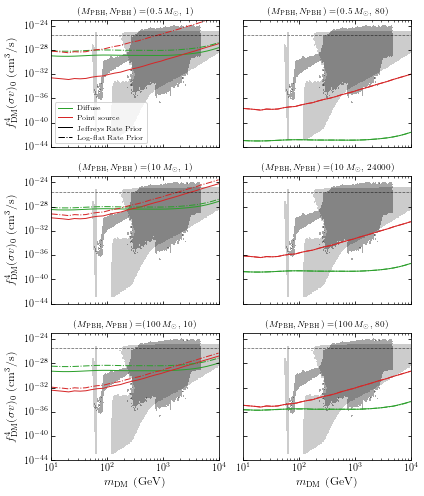

In [111]:
fig, axes = plt.subplots(n_pbhs.shape[0], n_pbhs.shape[1],
                         sharex=True, sharey=True,
                         figsize=(6, 7))


for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        ax = axes[i, j]
        m_pbh = m_pbhs[i, j]
        n_pbh = n_pbhs[i, j]
        
        for prior, ls in zip(["J", "LF"], ['-', '-.']):
            # Diffuse limit
            post_diff = DiffusePosterior(m_pbh, n_pbh, test=False,
                                         merger_rate_prior=prior)
            m_dms, sv_diff_bounds = post_diff.sv_bounds(save=False, alpha=0.95)
            print(m_pbh, n_pbh, sv_diff_bounds[0])
            lab = "Diffuse" if prior == "J" else ""
            ax.loglog(m_dms, sv_diff_bounds, label=lab, linestyle=ls, color=colors[2])

            # Point source limit
            post_ps = PointSourcePosterior(m_pbh, n_pbh, test=False,
                                           merger_rate_prior=prior, sv_prior=sv_prior)
            m_dms, sv_ps_bounds = post_ps.sv_bounds(save=False, alpha=0.95)
            lab = "Point source" if prior == "J" else ""
            ax.loglog(m_dms, sv_ps_bounds, label=lab, linestyle=ls, color=colors[3])
        
        # BSM physics contours
        plot_gambit_contour_envelope(ax, 'k')
        # Thermal relic cross section
        ax.axhline(3e-26, linestyle='--', color='k', alpha=0.6, linewidth=0.75)

        # Formatting
        ax.set_xlim(m_dms[[0, -1]])
        ax.set_ylim(1e-44, 1e-23)
        ax.set_title(r"$(M_{\mathrm{PBH}}, N_{\mathrm{PBH}}) = $" +
                     "({:g} $M_\odot$, {:d})".format(m_pbh, n_pbh), fontsize=9.0)
        if i == axes.shape[0] - 1:
            ax.set_xlabel(r"$m_{\mathrm{DM}}$ (GeV)", fontsize=12)
        if j == 0:
            ax.set_ylabel(r"$f_{\mathrm{DM}}^4 (\sigma v)_0$ (cm$^3$/s)", fontsize=12)
        if i == 0 and j == 0:
            ax.plot([1e-50, 1e-50], [1e-50, 1e-50], color='k', linestyle='-', label='Jeffreys Rate Prior')
            ax.plot([1e-50, 1e-50], [1e-50, 1e-50], color='k', linestyle='-.', label='Log-flat Rate Prior')
            ax.legend(fontsize=7)

fig.tight_layout()
fig.savefig("figures/sv_limits_ps_diff_comparison.pdf", bbox_inches='tight',pad_inches = 0.05)

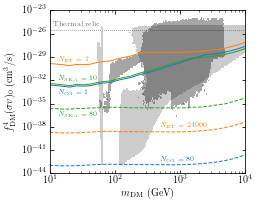

In [112]:
#fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.7))
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.0))

for i in range(m_pbhs.shape[0]):
    for j, ls in zip(range(n_pbhs.shape[1]), ["-", "--"]):
        m_pbh = m_pbhs[i, j]
        n_pbh = n_pbhs[i, j]

        # Plot strongest gamma-ray constraint
        post_diff = DiffusePosterior(m_pbh, n_pbh, test=False,
                                     merger_rate_prior=merger_rate_prior)
        post_ps = PointSourcePosterior(m_pbh, n_pbh, test=False,
                                       merger_rate_prior=merger_rate_prior)
        m_dms, sv_diff_bounds = post_diff.sv_bounds(save=False, alpha=0.95)
        m_dms, sv_ps_bounds = post_ps.sv_bounds(save=False, alpha=0.95)
        ax.loglog(m_dms, np.min([sv_diff_bounds, sv_ps_bounds], axis=0),
                  color=pbh_colors[m_pbh], linestyle=ls, linewidth=1)
        
# BSM physics contours
plot_gambit_contour_envelope(ax, 'k')
# Thermal relic cross section
ax.axhline(3e-26, linestyle=':', color='k', alpha=0.6, linewidth=0.75)
ax.text(1.12e1, 7e-26, "Thermal relic", alpha=0.6, fontsize=7)
# Unitarity bound
#eps = 1  # <sigma v>_0 / <sigma v>
#ax.plot(m_dms, eps * 3e-30 * (m_dms / 1e3)**2,
#        linestyle=':', color='k', alpha=0.6, linewidth=0.75)
#ax.plot(m_dms, 3e-30 * (m_dms / 1e3)**2,
#        linestyle=':', color='k', alpha=0.6, linewidth=0.75)
# ax.text(3e3, 8e-34, "Unitarity", fontsize=6, rotation=14, alpha=0.6)

# Formatting
ax.set_xlim(m_dms[[0, -1]])
ax.set_ylim(1e-44, 1e-23)
ax.set_xlabel(r"$m_{\mathrm{DM}}$ (GeV)", fontsize=10.0)
ax.set_ylabel(r"$f_{\mathrm{DM}}^4 (\sigma v)_0$ (cm$^3$/s)", fontsize=10.0)
# N_min labels
ax.text(1.35e1, 2e-30, r"$N_{\mathrm{ET}} = 1$", fontsize=7, color=pbh_colors[10])
ax.text(1.35e1, 6e-33, r"$N_{\mathrm{SKA}} = 10$", fontsize=7, color=pbh_colors[100])
ax.text(1.35e1, 1.5e-34, r"$N_{\mathrm{O3}} = 1$", fontsize=7, color=pbh_colors[0.5])
# N_max labels
ax.text(1.35e1, 1.5e-37, r"$N_{\mathrm{SKA}} = 80$", fontsize=7, color=pbh_colors[100])
ax.text(5e2, 5e-39, r"$N_{\mathrm{ET}} = 24000$", fontsize=7, color=pbh_colors[10])
ax.text(5e2, 3e-43, r"$N_{\mathrm{O3}} = 80$", fontsize=7, color=pbh_colors[0.5])

#fig.tight_layout()
fig.savefig("figures/sv_limits.pdf", bbox_inches='tight',pad_inches = 0.05)

# Scratch

In [1]:
from posterior_inference_shared import Distribution_f

In [10]:
p_f = Distribution_f(m_pbh=10, n_pbh=1, merger_rate_prior="LF")

In [15]:
p_f.m_pbh = 0.01

ValueError: p(f|n_pbh) has not been calculated for this PBH mass

In [14]:
p_f(1e-4)

array(4.69992612)

In [139]:
from constants import gamma_tr_sample

In [155]:
gamma_tr_sample(np.array([1., 3, 3, 3]), np.array([[0.1]]), shape=np.array([1., 1.1, 1.2, 1.3]))

array([[0.62684175, 1.49698622, 0.385131  , 0.6099357 ]])

In [136]:
from constants import m_mw_dm

In [138]:
m_mw_dm / 1e12

3.165431140186273

In [4]:
import numpy as np
from pbhhalosim import PBHHaloSim

In [15]:
np.random.seed(10)
sim = PBHHaloSim(m_pbh=0.5, f=1e-3, m_dm=100, sv=1e-32)
sim.run(False, False)

In [16]:
sim.pr_det, sim.pr_det_err

(0.0, 0.0)

In [133]:
sim.pr_det, sim.pr_det_err

(1.3549780826848406e-07, 3.66553077290773e-10)

In [131]:
4.29e-8 / 1.35e-7

0.31777777777777777

Text(0.5, 1.0, '$(M_{\\mathrm{PBH}}, f_{\\mathrm{PBH}}) = $(0.5 $M_\\odot$, $10^2$)')

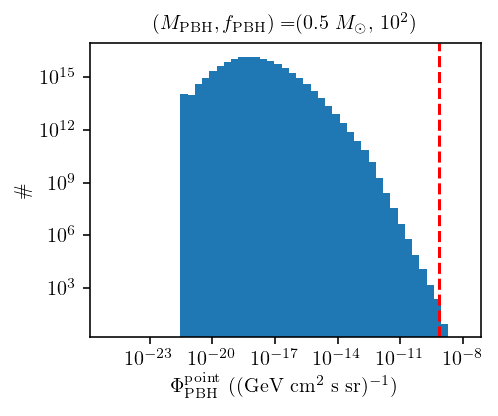

In [123]:
plt.figure(figsize=(3.5, 2.7))

counts, bins, _ = plt.hist(sim.fluxes, bins=10**np.linspace(-25, -8, 50), density=True)
plt.axvline(sim.flux_thresh, linestyle='--', color='r')

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\Phi_{\mathrm{PBH}}^{\mathrm{point}}$ ((GeV cm$^2$ s sr)$^{-1}$)")
plt.ylabel("\#")
plt.title(r"$(M_{\mathrm{PBH}}, f_{\mathrm{PBH}}) = $(0.5 $M_\odot$, $10^2$)", fontsize=10)

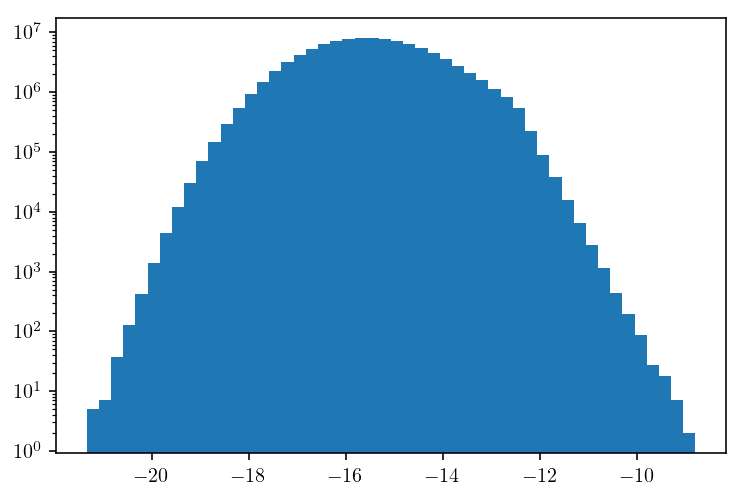

In [122]:
plt.hist(np.log10(sim.fluxes), bins=50);
plt.yscale("log")

In [117]:
np.mean(sim.fluxes)  # 1e-31

1.3735196367980507e-14

In [115]:
np.mean(sim.fluxes)  # 1e-32

6.4655594714520036e-15